In [41]:
!pip install git+git://github.com/geopandas/geopandas.git
!pip install earthpy
!pip install descartes # required for plotting polygons in geopandas

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-el5m52ug
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-el5m52ug
  Created wheel for geopandas: filename=geopandas-0.8.0+55.g924cdf6-py2.py3-none-any.whl size=970002 sha256=280cdb14ca34b10ee7a5845009d64b06bb7db344b91e25c1be1f1fb4d42531b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-94chqa9r/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas


In [42]:
# import necessary packages
%matplotlib inline
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import pandas as pd
from tqdm.notebook import tqdm
pd.options.mode.chained_assignment = None  # default='warn'

# Understanding the Shape File

In [43]:
# Load the shape file from github
!wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
!unzip -nq la_shape.zip -d shape

This part will help us understand what the Los Angeles County shapefile contains

In [44]:
# Let's take a look at the shapefile
neighborhood_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
print(neighborhood_shapes.head()) # view the data attribute table 
print("Shape: ", neighborhood_shapes.shape)
print(neighborhood_shapes.columns)

              slug  ...                                           geometry
0            acton  ...  POLYGON ((-118.20262 34.53899, -118.18947 34.5...
1  adams-normandie  ...  POLYGON ((-118.30901 34.03741, -118.30041 34.0...
2     agoura-hills  ...  POLYGON ((-118.76193 34.16820, -118.72632 34.1...
3       agua-dulce  ...  POLYGON ((-118.25468 34.55830, -118.25551 34.5...
4         alhambra  ...  POLYGON ((-118.12175 34.10504, -118.11687 34.1...

[5 rows x 11 columns]
Shape:  (272, 11)
Index(['slug', 'set', 'kind', 'external_i', 'name', 'display_na', 'sqmi',
       'type', 'name_1', 'slug_1', 'geometry'],
      dtype='object')


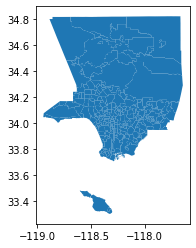

In [45]:
neighborhood_shapes.plot()

# Understanding the Nursing Home Data


In [46]:
!wget --directory-prefix=data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/Nursing_Homes_Raw.csv
nursing_homes_filename = 'data/Nursing_Homes_Raw.csv'

nursing_home_data = pd.read_csv(nursing_homes_filename)
nursing_home_data.rename(columns={'BEDS': 'Beds', 'LATITUDE': 'Latitude', 'LONGITUDE': 'Longitude'}, inplace=True)

In [47]:
nursing_home_data.head()

,NAME,ADDRESS,CITY,STATE,ZIP,POPULATION,COUNTY,Latitude,Longitude,Beds
0,CULPEPPER'S HOME #2,3616 10TH AVENUE,LOS ANGELES,CA,90018,15,LOS ANGELES,34.022376,-118.328043,15
1,SOUTHSIDE MANOR,820 EAST GRAND AVENUE,POMONA,CA,91766,38,LOS ANGELES,34.048060,-117.740399,38
2,VILLA STANLEY EAST INC.,7253 MELROSE AVENUE,LOS ANGELES,CA,90046,62,LOS ANGELES,34.083786,-118.347639,62
3,COUNTRY VIEW RETIREMENT HOME,824 W. CAMERON AVE.,WEST COVINA,CA,91790,136,LOS ANGELES,34.061876,-117.933062,136
4,BEVERLY HILLS GARDENS CARE CENTER,1470 S. ROBERTSON BLVD,LOS ANGELES,CA,90035,110,LOS ANGELES,34.052722,-118.383780,110


In [48]:
nursing_home_data.describe()

,ZIP,POPULATION,Latitude,Longitude,Beds
count,812.000000,812.000000,812.000000,812.000000,812.000000
mean,90857.956897,94.548030,34.057253,-118.229721,94.548030
std,702.333598,72.182338,0.152603,0.195716,72.182338
min,90004.000000,4.000000,33.339190,-118.740057,4.000000
25%,90221.750000,44.000000,33.969212,-118.357739,44.000000
50%,90805.000000,89.500000,34.070356,-118.260204,89.500000
75%,91355.250000,125.000000,34.142428,-118.122656,125.000000
max,93543.000000,574.000000,34.704958,-117.715380,574.000000


# Polygon Intersection

In [49]:
from shapely.geometry import Point, Polygon
neighborhood_shapes = neighborhood_shapes[['name','geometry']]

neighborhood_data = pd.DataFrame(neighborhood_shapes['name'])
neighborhood_data.rename(columns={'name': 'Neighborhood'}, inplace=True)
neighborhood_data["NursingHomeBeds"] = 0
polys = neighborhood_shapes['geometry']

for idx, row in tqdm(nursing_home_data.iterrows(), total=nursing_home_data.shape[0]):
  mask = polys.contains(Point(row['Longitude'], row['Latitude']))
  # This Census Tract from the Census Data belongs to this particular neighborhood
  neighborhood_row = neighborhood_shapes[mask]
  if (len(neighborhood_row) == 0):
    # Unknown neighborhood - doesn't fall in any polygon
    print(row)
    continue
  neighborhood = neighborhood_row.iloc[0]

  # Aggregate number of beds
  previous_value = neighborhood_data.loc[neighborhood_row.index, "NursingHomeBeds"].iloc[0]
  neighborhood_data.at[neighborhood_row.index, "NursingHomeBeds"] = previous_value + row["Beds"]

NAME          WILLIAMS' GUEST HOME
ADDRESS          1702 CRENSHAW BL.
CITY                   LOS ANGELES
STATE                           CA
ZIP                          90019
POPULATION                      11
COUNTY                 LOS ANGELES
Latitude                   34.0434
Longitude                 -118.329
Beds                            11
Name: 556, dtype: object



In [50]:
neighborhood_data.head()

,Neighborhood,NursingHomeBeds
0,Acton,0
1,Adams-Normandie,90
2,Agoura Hills,185
3,Agua Dulce,0
4,Alhambra,1105


In [51]:
# Ensure missing data is actually 0
neighborhood_data.fillna(0)
num_total_beds = sum(neighborhood_data['NursingHomeBeds'])
neighborhood_data['% of NursingHomeBeds'] = neighborhood_data['NursingHomeBeds'] * 100.0 / num_total_beds

neighborhood_data.to_csv('nursing_home_processed_data.csv', encoding='utf-8', index=False)